In [1]:
import glob
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from matplotlib import ticker

sb.set()

# you will probably have to change this
file_pattern = "./results/stdout/out_*.txt"
stdout_files = glob.glob(file_pattern)

print(stdout_files)

['./results/stdout\\out_1.txt', './results/stdout\\out_1024.txt', './results/stdout\\out_128.txt', './results/stdout\\out_16.txt', './results/stdout\\out_16384.txt', './results/stdout\\out_2.txt', './results/stdout\\out_2048.txt', './results/stdout\\out_256.txt', './results/stdout\\out_32.txt', './results/stdout\\out_4.txt', './results/stdout\\out_4096.txt', './results/stdout\\out_512.txt', './results/stdout\\out_64.txt', './results/stdout\\out_8.txt', './results/stdout\\out_8192.txt']


In [7]:
# these are the only relevant ones, at least
patterns = {
    "num_worlds": r"Running with (\d+) Worlds:",
    "allocating": r"\[INFO\] Allocating (\d+) of (\d+) bytes on device",
    "actual_program_time": r"\[BENCHMARK\] Actual program time: ([\d\.]+) ms",
    "avg_simulateKernel_time": r"\[BENCHMARK\] Average individual simulateKernel\(\) time over (\d+) samples: ([\d\.]+) ms",
    "total_kernel_time": r"\[BENCHMARK\] Total time spent in kernel before global convergence: ([\d\.]+) ms",
    "kernel_time_ratio": r"\[BENCHMARK\] Kernel time / total program time: ([\d\.]+)",
}

data = {f"before_{k}":[] for k in patterns}
data.update({f"after_{k}":[] for k in patterns})

for filename in stdout_files:
    with open(filename, 'r') as f:
        content = f.read()

    # let me put you on game: put any string in a quick cmd -> py -> len("<string>")
    sep = content.split("-" * 27)

    # there is an invalid - * 27 at the top line
    for i, partition in enumerate(sep[1:]):
        part = "before" if i == 0 else "after"
        for key, pattern in patterns.items():
            match = re.search(pattern, partition)
            if match:
                values = [float(x) if '.' in x else int(x) for x in match.groups()]
                
                if key == "avg_simulateKernel_time":
                    values = values[1:]
                elif key == "allocating":
                    values = values[:1]       
                data[f"{part}_{key}"].append(values[0] if len(values) == 1 else values)

print(data)

{'before_num_worlds': [1, 1024, 128, 16, 16384, 2, 2048, 256, 32, 4, 4096, 512, 64, 8, 8192], 'before_allocating': [2304, 2359296, 294912, 36864, 37748736, 4608, 4718592, 589824, 73728, 9216, 9437184, 1179648, 147456, 18432, 18874368], 'before_actual_program_time': [189, 480, 372, 261, 2100, 186, 538, 400, 296, 207, 618, 424, 336, 229, 1255], 'before_avg_simulateKernel_time': [0.021439, 0.053425, 0.048564, 0.031946, 0.140693, 0.020651, 0.057941, 0.052087, 0.037169, 0.023787, 0.07752, 0.055162, 0.043263, 0.027232, 0.088632], 'before_total_kernel_time': [140.960938, 412.655151, 321.733337, 210.749741, 1740.0896, 135.427505, 457.67923, 347.003906, 245.912399, 156.805771, 526.127014, 369.472656, 286.231262, 179.978073, 1026.355591], 'before_kernel_time_ratio': [0.745825, 0.859698, 0.864875, 0.80747, 0.828614, 0.728105, 0.850705, 0.86751, 0.830785, 0.757516, 0.851338, 0.871398, 0.851879, 0.78593, 0.817813], 'after_num_worlds': [1, 1024, 128, 16, 16384, 2, 2048, 256, 32, 4, 4096, 512, 64, 8,

In [8]:
df = pd.DataFrame(data)
df = df.sort_values(by="before_num_worlds")
print(df.head())

    before_num_worlds  before_allocating  before_actual_program_time  \
0                   1               2304                         189   
5                   2               4608                         186   
9                   4               9216                         207   
13                  8              18432                         229   
3                  16              36864                         261   

    before_avg_simulateKernel_time  before_total_kernel_time  \
0                         0.021439                140.960938   
5                         0.020651                135.427505   
9                         0.023787                156.805771   
13                        0.027232                179.978073   
3                         0.031946                210.749741   

    before_kernel_time_ratio  after_num_worlds  after_allocating  \
0                   0.745825                 1              2304   
5                   0.728105                 2

In [9]:
worlds = sorted(list(df["before_num_worlds"].unique()))

x_ticks = range(len(worlds))
x_labels = [f"$2^{{{int(n)}}}$" for n in range(len(worlds))]

plt.rcParams["font.family"] = "serif"

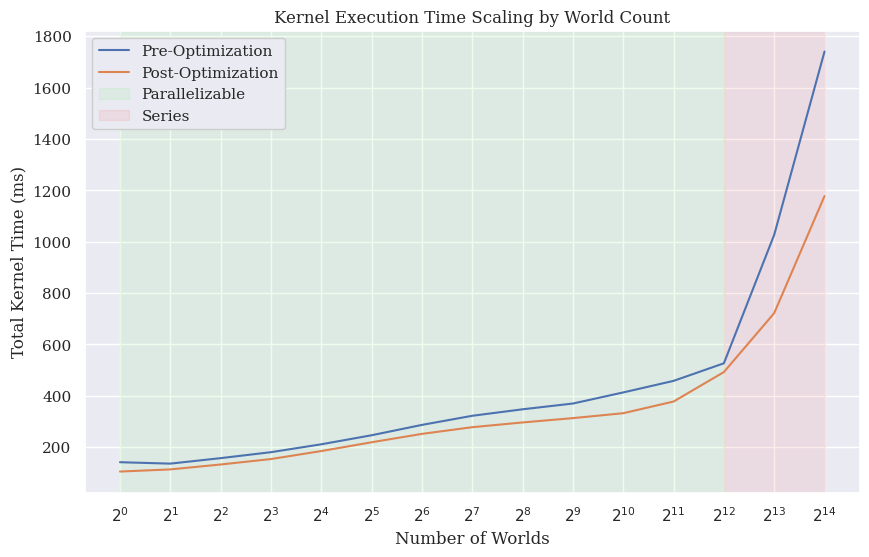

In [21]:
plt.figure(figsize=(10, 6))
plt.title("Kernel Execution Time Scaling by World Count")

sb.lineplot(x=x_ticks, y=df["before_total_kernel_time"], label="Pre-Optimization")
sb.lineplot(x=x_ticks, y=df["after_total_kernel_time"], label="Post-Optimization")

plt.xticks(x_ticks, x_labels)
plt.xlabel("Number of Worlds")
plt.ylabel("Total Kernel Time (ms)")

plt.axvspan(0, 12, color='lightgreen', alpha=0.15, label="Parallelizable")
plt.axvspan(12, max(x_ticks), color='lightcoral', alpha=0.15, label="Series")

plt.legend(framealpha=1, loc="upper left")
plt.grid(True)
plt.savefig("../docs/figures/totalKernelTime_x_worldCt.png", dpi=300)
plt.show()

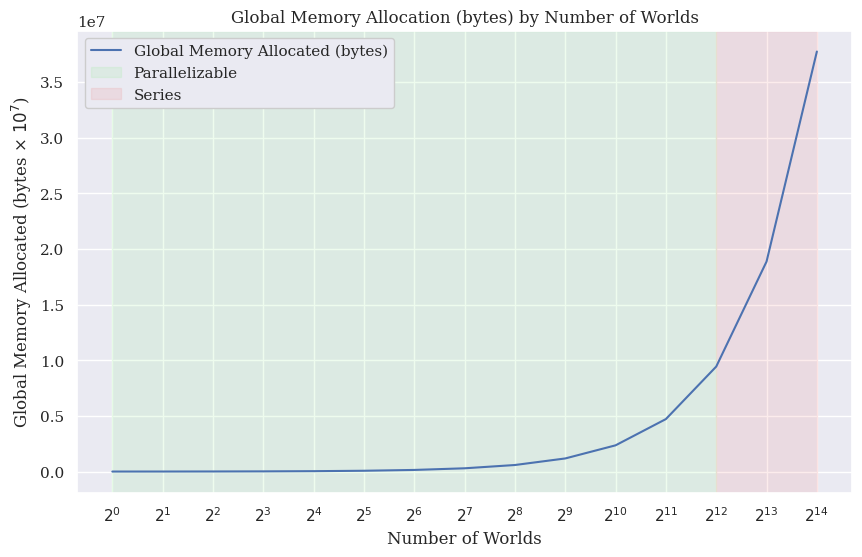

In [22]:
plt.figure(figsize=(10, 6))
plt.title("Global Memory Allocation (bytes) by Number of Worlds")

sb.lineplot(x=x_ticks, y=df["after_allocating"], label="Global Memory Allocated (bytes)")

plt.xticks(x_ticks, x_labels)
plt.xlabel("Number of Worlds")
plt.ylabel("Global Memory Allocated (bytes × $10^7$)")

plt.axvspan(0, 12, color='lightgreen', alpha=0.15, label="Parallelizable")
plt.axvspan(12, max(x_ticks), color='lightcoral', alpha=0.15, label="Series")

plt.legend(framealpha=1, loc="upper left")
plt.grid(True)
plt.savefig("../docs/figures/globalMemory_x_worldCt.png", dpi=300)
plt.show()